In [ ]:
import os
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


## **PETUNJUK UNTUK INFERENCE**
1. Import notebook ini ke Kaggle, lalu atur acceleratornya ke GPU P100
2. Pastikan lakukan *add input* untuk dapat menggunakan dataset hasil preprocess kami yang ada pada tautan https://www.kaggle.com/datasets/nafalrust/mistargawang-hologyori
3. Lakukan *add input* untuk model kami yang ada pada tautan https://www.kaggle.com/models/nafalrust/mistar-gawang-hology-data-mining-cctrans atau masukkan model lain secara manual
4. Ganti direktori model pada cell 4 dengan yang diinginkan `model_pattern = '/kaggle/input/mistargawang-hologycp/transformer_cp_done/best_model_mae-16.28_epoch-200.pth'`
5. Jalankan cell 1, cell 2, dan cell 4
6. Hasil inference tersimpan di */kaggle/working/cctrans/predictions.csv*

# **HOLOGY UB 8.0: Data Mining**

<br>

## Tim ***Mistar Gawang***
### Muhammad Zufar Syaafi  
### Muhammad Nafal Zakin Rustanto  
### Alfito Putra Parindra  
### ***Universitas Gadjah Mada***


## **CASE UNDERSTANDING**
Abi adalah petugas perencanaan kota di Badan Pengelola Kota Cerdas Nusantara. Dalam waktu dekat, kota ini akan mengadakan Festival Harmoni Nusantara, sebuah perayaan budaya nasional yang diperkirakan akan menarik ratusan ribu pengunjung dari seluruh Indonesia.

Abi menghadapi sebuah tantangan kompleks: bagaimana cara memantau potensi terjadinya overcrowding. Tujuannya untuk mencegah potensi overcrowding atau kemacetan, mengidentifikasi kepadatan, mengoptimalkan jalur evakuasi, dan memastikan pengalaman pengunjung tetap aman serta menyenangkan. Abi memutuskan untuk membuat sebuah model AI yang dapat menghitung jumlah kerumunan secara akurat dari tiap gambar yang ditangkap dari kamera pengintai.

Di sini, misi Anda adalah membantu Abi dengan mengembangkan model AI yang dapat menghitung jumlah kerumunan (crowd counting) secara akurat. Teknologi ini akan membantu mewujudkan visi kota cerdas yang aman dan efisien.

Anda diminta untuk membangun model untuk menghitung jumlah orang dalam gambar di berbagai kondisi dan tantangan yang kompleks. Model yang Anda kembangkan harus dapat menghadapi berbagai macam tantangan seperti variasi perspektif pengambilan gambar, kepadatan beragam dari area sepi hingga kerumunan padat, berbagai kondisi lingkungan dan pencahayaan, hingga skala multi-level dan oklusi.

Dalam training set, Anda memiliki 1,900 gambar beserta label ground truth yang menunjukkan lokasi setiap orang. Model Anda perlu memprediksi jumlah total orang dalam sebuah gambar test set.

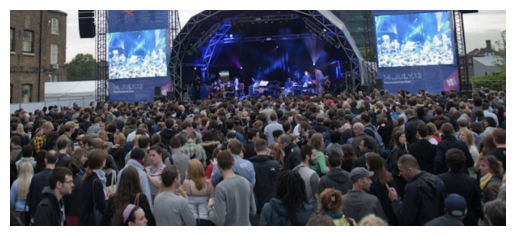

In [14]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("D:\\penyisihan-hology-8-0-2025-data-mining\\1.png")
if img is not None:
	img = img[:,:,::-1]  # Convert BGR to RGB
	plt.imshow(img)
	plt.axis("off")
	plt.show()
else:
	print("Image '1.png' not found or could not be loaded.")


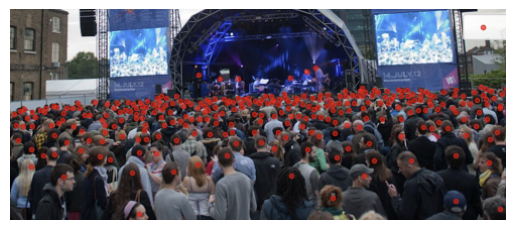

In [15]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("D:\\penyisihan-hology-8-0-2025-data-mining\\2.png")
if img is not None:
	img = img[:,:,::-1]  # Convert BGR to RGB
	plt.imshow(img)
	plt.axis("off")
	plt.show()
else:
	print("Image '1.png' not found or could not be loaded.")

Data gambar yang tersedia memiliki ukuran dari 300x200 hingga 1920x1000. Data gambar memiliki label mulai 1 orang dalam kerumuman hingga 3139 orang dalam kerumunan, berbentuk json, dimana data cukup unbalance (jumlah gambar dengan jumlah kerumunan kecil jauh lebih besar)

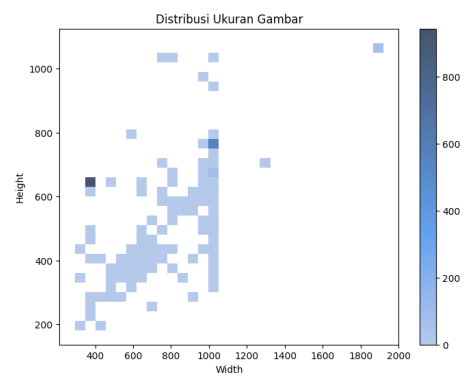

In [16]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("D:\\penyisihan-hology-8-0-2025-data-mining\\3.png")
if img is not None:
	img = img[:,:,::-1]  # Convert BGR to RGB
	plt.imshow(img)
	plt.axis("off")
	plt.show()
else:
	print("Image '1.png' not found or could not be loaded.")


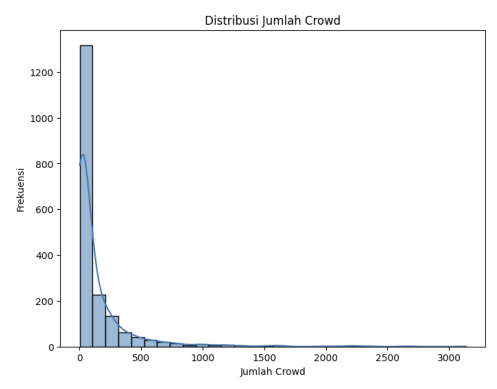

In [17]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("D:\\penyisihan-hology-8-0-2025-data-mining\\4.png")
if img is not None:
	img = img[:,:,::-1]  # Convert BGR to RGB
	plt.imshow(img)
	plt.axis("off")
	plt.show()
else:
	print("Image '1.png' not found or could not be loaded.")


## **DATA PREPROCESS**
### **Konversi Label**
Label pada data training dikonversi dari format *.json* menjadi list koordinat kerumunan dalam format *.txt* untuk mempermudah pengolahan data dan training
Konversi label dilakukan dengan kode python berikut ini
```
import os
import json

# Path folder label
json_dir = "train/labels"
txt_dir = "train/labels_txt"

# Buat folder output jika belum ada
os.makedirs(txt_dir, exist_ok=True)

for jf in os.listdir(json_dir):
    if not jf.endswith(".json"):
        continue
    
    with open(os.path.join(json_dir, jf), "r") as f:
        data = json.load(f)
    
    points = data.get("points", [])
    
    # nama file txt sama dengan nama file gambar
    txt_name = os.path.splitext(jf)[0] + ".txt"
    txt_path = os.path.join(txt_dir, txt_name)
    
    with open(txt_path, "w") as out:
        for p in points:
            out.write(f"{p['x']} {p['y']}\n")

print("Konversi selesai! Semua label JSON → TXT tersimpan di:", txt_dir)
```
<br>

### **Data Split**
Sebelum diproses lebih lanjut, kami memisahkan 20% gambar (380 gambar) dari dataset secara random (dengan `random.seed(42)`) untuk menjadi data validasi, yang digunakan dalam proses training model nantinya

<br>

### **Augmentasi dan Transformasi Data**
Untuk meningkatkan performa dan robustness model, dilakukan augmentasi dan transformasi untuk memperbanyak jumlah dan variasi data. Augmentasi dan transformasi dilakukan dengan melakukan perubahan random pada data yaitu random crop, random brightness, contrast, color jitter, random flip, mozaic dan mixup. Augmentasi dilakukan sekaligus untuk mengupayakan balancing, dimana gambar dengan jumlah kerumunan banyak akan diaugmentasi lebih sering. Augmentasi dilakukan dengan kode python berikut

```
import os
import random
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

train_dir = "./train"
aug_dir = "./train_aug2"
os.makedirs(aug_dir, exist_ok=True)

# --------------------------------
# Util untuk label titik
# --------------------------------
def read_points(txt_path):
    points = []
    with open(txt_path, "r") as f:
        for line in f:
            if line.strip():
                x, y = map(float, line.strip().split())
                points.append((x, y))
    return points

def save_points(points, save_path):
    with open(save_path, "w") as f:
        for (x, y) in points:
            f.write(f"{x:.2f} {y:.2f}\n")

# --------------------------------
# Augmentasi dasar
# --------------------------------
def flip_horizontal(img, points):
    w, h = img.size
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    points = [(w - x, y) for (x, y) in points]
    return img, points

def adjust_brightness(img, points, factor=1.5):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor), points

def adjust_contrast(img, points, factor=1.5):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor), points

def color_jitter(img, points):
    img, points = adjust_brightness(img, points, factor=random.uniform(0.7, 1.3))
    img, points = adjust_contrast(img, points, factor=random.uniform(0.7, 1.3))
    return img, points

def random_crop(img, points, crop_ratio=0.8):
    w, h = img.size
    crop_size = int(min(w, h) * crop_ratio)
    x0 = random.randint(0, w - crop_size)
    y0 = random.randint(0, h - crop_size)
    img_crop = img.crop((x0, y0, x0+crop_size, y0+crop_size))
    img_crop = img_crop.resize((w, h))
    points_crop = [(x-x0, y-y0) for (x,y) in points if x0 <= x < x0+crop_size and y0 <= y < y0+crop_size]
    return img_crop, points_crop

AUGMENT_METHODS = {
    "flip": flip_horizontal,
    "brightness": adjust_brightness,
    "contrast": adjust_contrast,
    "jitter": color_jitter,
    "crop": random_crop,
}

# --------------------------------
# Augmentasi kombinasi
# --------------------------------
def augment_image(img_path, txt_path, idx, max_aug=2):
    img = Image.open(img_path).convert("RGB")
    points = read_points(txt_path)

    methods = random.sample(list(AUGMENT_METHODS.keys()), k=random.randint(1, max_aug))
    aug_img, aug_points = img, points
    aug_name = f"{idx}"

    for m in methods:
        aug_img, aug_points = AUGMENT_METHODS[m](aug_img, aug_points)
        aug_name += f"_{m}"

    save_img_path = os.path.join(aug_dir, f"{aug_name}.jpg")
    save_txt_path = os.path.join(aug_dir, f"{aug_name}.txt")

    aug_img.save(save_img_path)
    save_points(aug_points, save_txt_path)

    return os.path.basename(save_img_path)

# --------------------------------
# Mosaic & MixUp
# --------------------------------
def mosaic_augment(img_paths, txt_paths, out_name, out_size=(512, 512)):
    imgs = [Image.open(p).convert("RGB") for p in img_paths]
    points_list = [read_points(p) for p in txt_paths]
    
    w, h = out_size
    out_img = Image.new("RGB", out_size)
    new_points = []

    coords = [(0,0), (w//2,0), (0,h//2), (w//2,h//2)]
    for idx, (img, pts, (x_off, y_off)) in enumerate(zip(imgs, points_list, coords)):
        img = img.resize((w//2, h//2))
        out_img.paste(img, (x_off, y_off))
        for (x,y) in pts:
            new_points.append((x / img.width * (w//2) + x_off,
                               y / img.height * (h//2) + y_off))
    
    save_img_path = os.path.join(aug_dir, f"{out_name}_mosaic.jpg")
    save_txt_path = os.path.join(aug_dir, f"{out_name}_mosaic.txt")
    out_img.save(save_img_path)
    save_points(new_points, save_txt_path)
    return os.path.basename(save_img_path)

def mixup_augment(img1_path, txt1_path, img2_path, txt2_path, out_name, alpha=0.5):
    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")
    pts1, pts2 = read_points(txt1_path), read_points(txt2_path)

    w, h = img1.size
    img2 = img2.resize((w,h))
    mixed = Image.blend(img1, img2, alpha=alpha)
    new_points = pts1 + pts2

    save_img_path = os.path.join(aug_dir, f"{out_name}_mixup.jpg")
    save_txt_path = os.path.join(aug_dir, f"{out_name}_mixup.txt")
    mixed.save(save_img_path)
    save_points(new_points, save_txt_path)
    return os.path.basename(save_img_path)

# --------------------------------
# Step 1: Copy semua original
# --------------------------------
img_files = sorted(glob(os.path.join(train_dir, "*.jpg")))
txt_files = [f.replace(".jpg", ".txt") for f in img_files]

for img, txt in tqdm(zip(img_files, txt_files), total=len(img_files), desc="Copy original"):
    base = os.path.basename(img)
    os.system(f"cp '{img}' '{os.path.join(aug_dir, base)}'")
    os.system(f"cp '{txt}' '{os.path.join(aug_dir, base.replace('.jpg','.txt'))}'")

# --------------------------------
# Step 2: Distribusi awal
# --------------------------------
counts = [len(read_points(txt)) for txt in txt_files]
plt.hist(counts, bins=10)
plt.title("Distribusi sebelum augmentasi")
plt.show()

bins = np.linspace(min(counts), max(counts), 11)
bin_indices = np.digitize(counts, bins)
unique, freqs = np.unique(bin_indices, return_counts=True)
target = max(freqs)

# --------------------------------
# Step 3: Augmentasi balancing
# --------------------------------
augmented_files = []
for i, (img, txt, c, b) in enumerate(zip(img_files, txt_files, counts, bin_indices)):
    need = target - freqs[np.where(unique == b)[0][0]]
    if need > 0:
        for _ in range(min(8, need)):
            new_file = augment_image(img, txt, f"{i}_{_}", max_aug=2)
            augmented_files.append(new_file)

# --------------------------------
# Step 4: Tambahan Mosaic & MixUp (maks 10% dataset)
# --------------------------------
n_total = len(img_files)
n_mosaic = int(0.1 * n_total)
n_mixup = int(0.1 * n_total)

for k in range(n_mosaic):
    chosen_idx = random.sample(range(len(img_files)), 4)
    img_paths = [img_files[j] for j in chosen_idx]
    txt_paths = [txt_files[j] for j in chosen_idx]
    new_file = mosaic_augment(img_paths, txt_paths, out_name=f"mosaic_{k}")
    augmented_files.append(new_file)

for k in range(n_mixup):
    chosen_idx = random.sample(range(len(img_files)), 2)
    img1, img2 = img_files[chosen_idx[0]], img_files[chosen_idx[1]]
    txt1, txt2 = txt_files[chosen_idx[0]], txt_files[chosen_idx[1]]
    new_file = mixup_augment(img1, txt1, img2, txt2, out_name=f"mixup_{k}")
    augmented_files.append(new_file)

print(f"Total augmented images (balancing+Mosaic+MixUp): {len(augmented_files)}")

# --------------------------------
# Step 5: Buat train.list baru
# --------------------------------
all_imgs = sorted(glob(os.path.join(aug_dir, "*.jpg")))
with open(os.path.join(aug_dir, "train.list"), "w") as f:
    for img in all_imgs:
        f.write(os.path.basename(img) + "\n")

print("train.list baru sudah dibuat di train_aug2/")
```
---
<br>
Dataset yang disudah diproses selanjutnya diunggah ke Kaggle untuk proses pemodelan. Dataset dapat diakses pada tautan https://www.kaggle.com/datasets/nafalrust/mistargawang-hologyori.

## **Modelling**

### **Model yang Digunakan: CCTrans**

#### 1. Gambaran Umum
CCTrans adalah model *crowd counting* berbasis **Vision Transformer** yang dirancang untuk menyederhanakan pipeline perhitungan kerumunan sekaligus meningkatkan performa.  
Berbeda dari CNN tradisional yang kuat dalam mengekstrak fitur lokal namun lemah dalam menangkap konteks global, transformer mampu memodelkan **global receptive field** dengan lebih baik.
CCTrans dikembangkan oleh *Tian, et al (2021)* yang dipublikasi dalam sebuah paper berjudul *CCTrans: Simplifying and Improving Crowd Counting with Transformer* (https://arxiv.org/pdf/2109.14483)

Arsitektur CCTrans terdiri atas:
1. **Backbone Pyramid Vision Transformer (Twins-SVT)** – untuk ekstraksi fitur global.
2. **Pyramid Feature Aggregation (PFA)** – untuk menggabungkan fitur level rendah (detail spasial) dan fitur level tinggi (semantik).
3. **Regression Head dengan Multi-scale Dilated Convolution (MDC)** – untuk memprediksi *density map* secara akurat.
4. **Loss Functions khusus** – berbeda untuk *fully-supervised* dan *weakly-supervised* training.

---

#### 2. Alur Kerja Model
1. **Input Image → Patch Embedding**  
   - Gambar dibagi menjadi patch kecil berukuran *K × K × 3*.  
   - Setiap patch diflatten dan diproyeksikan ke vektor embedding.  
   - Hasilnya berupa **1D sequence** dari representasi gambar.

2. **Backbone: Pyramid Vision Transformer (Twins-SVT)**  
   - Menggunakan *alternated local self-attention (LSA)* dan *global sub-sampled attention (GSA)*.  
   - LSA: fokus pada detail lokal dalam jendela kecil.  
   - GSA: memungkinkan interaksi antar-jendela untuk menangkap konteks global.  
   - Hasilnya berupa fitur multi-level dari shallow hingga deep layer.

3. **Pyramid Feature Aggregation (PFA)**  
   - Fitur dari berbagai level backbone di-*reshape* kembali menjadi 2D feature maps.  
   - Semua feature maps di-*upsample* ke resolusi yang sama (1/8 dari input).  
   - Fitur digabung dengan *element-wise addition*, sehingga detail spasial + informasi semantik saling melengkapi.

4. **Regression Head: Multi-scale Dilated Convolution (MDC)**  
   - Terdiri dari beberapa cabang paralel dengan kernel size dan *dilation rate* berbeda (misalnya 1, 2, 3).  
   - Mencegah *gridding effect* yang biasanya muncul pada dilated conv berlapis.  
   - Output dari tiap cabang digabung, kemudian dilewatkan ke **1×1 Conv** untuk menghasilkan *density map*.  
   - *Density map* ini kemudian dijumlahkan pikselnya untuk menghasilkan estimasi jumlah orang.

---

#### 3. Loss Function
CCTrans menggunakan loss function yang berupa kombinasi dari
  - L1 Loss untuk jumlah orang total  
  - Optimal Transport (OT) Loss untuk meminimalkan perbedaan distribusi  
  - L2 Loss pada density map yang dihaluskan (*Gaussian kernel smoothing*)  

  Formula:  
  $$
  L_d = L_1(P, G) + \lambda_1 L_{OT} + \lambda_2 L_2(D, D')
  $$

---

#### 4. Visualisasi Arsitektur
Secara ringkas, alur CCTrans adalah:
**Input Image → Patch Embedding → Pyramid Transformer → PFA → MDC Regression Head → Density Map → Crowd Count**

---

Kode Implementasi Model (arsitektur, loss function, training loop, inference logic) dapat diakses di repository Github pada tautan https://github.com/nafalrust/CCTrans.git. Beberapa catatan terkait implementasi model, sebagai berikut
1. Model yang digunakan menggunakan model pretrained weights dari model ImageNet-1k untuk backbone, yang dapat diakses di /kaggle/input/mistargawang-hologyori/alt_gvt_large.pth
2. Parameter training dan test diatur melalui argumen dalam notebook ini

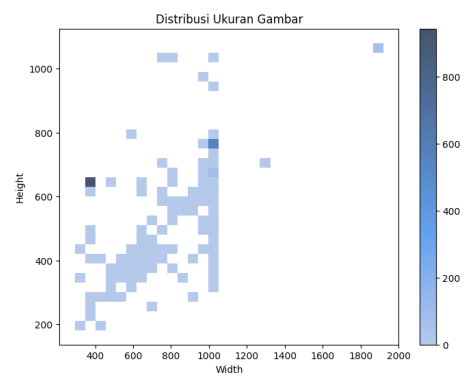

In [18]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("D:\\penyisihan-hology-8-0-2025-data-mining\\3.png")
if img is not None:
	img = img[:,:,::-1]  # Convert BGR to RGB
	plt.imshow(img)
	plt.axis("off")
	plt.show()
else:
	print("Image '1.png' not found or could not be loaded.")

### **Preparation**

Setup dan clone repository Github yang merupakan kode implementasi model (arsitektur, loss function, training loop, inference logic). Install library yang dibutuhkan dengan menjalankan `pip install -r requirements.txt`. Lalu cek ketersediaan sumber daya processing unit, notebook ini dijalankan di Kaggle dengan menggunakan GPU Tesla P100-PCIE-16GB

In [ ]:
#1

!pip install -q wandb scipy opencv-python

!git clone https://github.com/nafalrust/CCTrans.git /kaggle/working/cctrans
%cd /kaggle/working/cctrans
!pip install -q -r requirements.txt

import os
import sys
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import subprocess

sys.path.append('/kaggle/working/cctrans')

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name()}")

Inisiasi path untuk dataset yang akan digunakan. Direktori dataset berisi 3 folder yaitu train (berisi gambar training yang sudah ditransformasi dan augmentasi), valid (berisi 380 gambar untuk validasi yang sudah displit sebelumnya), dan test (berisi 500 gambar yang hasil inferencenya harus dikumpulkan). File `.list` dalam dataset berisi nama file untuk tiap kategori data (train, valid, test)

In [ ]:
#2

DATASET_PATH = '/kaggle/input/mistargawang-hologyori/trans'

print("Dataset structure:")
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files)-3} more files")

Dataset structure:
trans/
  valid.list
  train.list
  test.list
  valid/
    1711.txt
    623.jpg
    764.jpg
    ... and 757 more files
  test/
    361.txt
    208.jpg
    40.txt
    ... and 997 more files
  train/
    1893.txt
    1206_5_contrast_flip.jpg
    1427_6_flip_contrast.txt
    ... and 9416 more files


### **Training Proses**


Argumen/parameter training yang digunakan, sebagai berikut
1. `data-dir`: direktori dataset yang digunakan  
2. `dataset`: jenis dataset yang dipakai 
3. `crop-size`: ukuran crop pada gambar input sebelum masuk ke model  
4. `batch-size`: jumlah sampel per batch  
5. `lr`: learning rate awal untuk training  
6. `eta-min`: nilai minimum learning rate pada scheduler berbasis cosine annealing  
7. `weight-decay`: regularisasi L2 untuk mencegah overfitting  
8. `max-epoch`: jumlah maksimum epoch untuk training  
9. `wot`: bobot λ₁ untuk **Optimal Transport (OT) loss**  
10. `wtv`: bobot λ₂ untuk **Total Variation (TV) loss**  
11. `reg`: koefisien regularisasi tambahan  
12. `num-of-iter-in-ot`: jumlah iterasi untuk perhitungan OT loss  
13. `norm-cood`: normalisasi koordinat (0 = tidak digunakan, 1 = digunakan)  
14. `val-epoch`: frekuensi validasi (misalnya setiap 5 epoch)  
15. `val-start`: epoch mulai dilakukan validasi  
16. `num-workers`: jumlah worker DataLoader untuk loading data paralel  
17. `device`: ID GPU yang digunakan (`0` untuk GPU pertama)  
18. `run-name`: nama run untuk identifikasi hasil training
19. `wandb`: opsi logging ke Weights & Biases (`1` = aktif, `0` = nonaktif)  
20. `resume`: path ke checkpoint model untuk melanjutkan training sebelumnya  

In [ ]:
#3

import gc

train_args = [
    "python", "train.py",
    "--data-dir", DATASET_PATH,
    "--dataset", "custom",
    "--crop-size", "256",
    "--batch-size", "16",
    "--lr", "1e-5",
    "--eta-min", "1e-8",       
    "--weight-decay", "1e-4",
    "--max-epoch", "300",
    "--wot", "0.1",
    "--wtv", "0.01",
    "--reg", "10.0",
    "--num-of-iter-in-ot", "100",
    "--norm-cood", "0",
    "--val-epoch", "5",
    "--val-start", "10",
    "--num-workers", "4",
    "--device", "0",
    "--run-name", "crowd-counting1",
    "--wandb", "0",

    # isi dengan path checkpoint jika ingin melanjutkan training dari checkpoint tertentu
    # "--resume", "/kaggle/input/mistargawang-hologycp/transformer_cp_done/200_ckpt.tar"
]


print("Starting training with train.py...")
print(f"Command: {' '.join(train_args)}")

torch.cuda.empty_cache()
gc.collect()

try:
    print("=== Training Started (Real-time Output) ===")
    print("-" * 50)

    process = subprocess.Popen(
        train_args,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1,
        cwd="/kaggle/working/cctrans"
    )

    training_output = []
    while True:
        output = process.stdout.readline()
        if output == "" and process.poll() is not None:
            break
        if output:
            print(output.strip())
            training_output.append(output.strip())

    return_code = process.poll()
    print("-" * 50)

    if return_code == 0:
        print("Training completed successfully!")
    else:
        print(f"Training failed with return code: {return_code}")

    with open("./training_log.txt", "w") as f:
        f.write("\n".join(training_output))
    print("Training log saved to: ./training_log.txt")

except Exception as e:
    print(f"Error running training: {e}")
    import traceback
    traceback.print_exc()


### **Test/Inference**
Proses inference diawali dengan menginisiasi lokasi/direktori gambar yang akan diinference, lalu inisiasi path dari model yang akan digunakan. Selanjutnya, inisiasi beberapa argumen untuk mengatur beberapa parameter seperti yang tercantum pada file *predict.py* pada repository Github. Selanjutnya proses inference dimulai, cell di bawah ini akan memberikan output berupa informasi inference tiap gambarnya, hasil akan disimpan dalam folder */kaggle/working/cctrans/predictions.csv*. 


Argumen/parameter inference yang digunakan, sebagai berikut
1. `model-path`: direktori lokasi penyimpanan model, yang sudah diinisiasi sebelumnya
2. `input`: direktori lokasi penyimpanan data gambar, yang sudah diinisiasi sebelumnya
3. `output-csv`: nama file output
4. `crop-size`: ukuran crop pada gambar input sebelum masuk ke model (harus sama dengan training)

In [ ]:
#4

import os
import glob
import subprocess

TEST_IMAGES = "/kaggle/input/mistargawang-hologyori/trans/test"   # Inisiasi path dataset test (folder gambar)
model_pattern = '/kaggle/input/mistargawang-hologycp/transformer_cp_done/best_model_mae-16.28_epoch-200.pth' # inisiasi path model terbaik hasil training

model_files = glob.glob(model_pattern)
if model_files:
    latest_model = max(model_files, key=os.path.getmtime)
    print(f"Found trained model: {latest_model}")

    predict_args = [
        "python", "predict.py",
        "--model-path", latest_model,
        "--input", TEST_IMAGES,
        "--output-csv", "./predictions.csv",
        "--crop-size", "256"
    ]

    print("Starting prediction with predict.py...")
    print(f"Command: {' '.join(predict_args)}")

    try:
        print("=== Prediction Started (Real-time Output) ===")
        print("-" * 50)

        process = subprocess.Popen(
            predict_args,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1,
            cwd="/kaggle/working/cctrans"  
        )

        prediction_output = []
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None:
                break
            if output:
                print(output.strip())
                prediction_output.append(output.strip())

        return_code = process.poll()
        print("-" * 50)
        if return_code == 0:
            print("Prediction completed successfully!")
            print("Results saved to: ./predictions.csv")
        else:
            print(f"Prediction failed with return code: {return_code}")

        with open("./prediction_log.txt", "w") as f:
            f.write("\n".join(prediction_output))
        print("Prediction log saved to: ./prediction_log.txt")

    except Exception as e:
        print(f"Error running prediction: {e}")
        import traceback
        traceback.print_exc()

else:
    print("No trained model found!")


Model dengan score public terbaik dapat diakses pada tautan https://www.kaggle.com/models/nafalrust/mistar-gawang-hology-data-mining-cctrans atau https://drive.google.com/file/d/1LL3jOvsPLJcT1PX7HCcdPv-kAIHIYjXK/view?usp=sharing
Log training dapat diakses di https://drive.google.com/drive/folders/1_9xo6d92LM4N1gK4HCO0IZCH9PjiRLF2?usp=drive_link
Public Score Submission (MAE)
- 200 epoch: 14.67380
- 250 epoch: 15.14586

Notebook ini adalah notebook yang digunakan untuk submisi dengan skor public terbaik kami, terdapat notebook lainnya yang menggunakan model FFNet yang juga mendapatkan hasil yang cukup baik

- FFNet (Fuss-Free Network) adalah model crowd counting yang dirancang dengan prinsip sederhana dan efisien. Alih-alih menggunakan modul kompleks seperti attention berat atau fusi multi-cabang yang rumit, FFNet hanya mengandalkan backbone ringan (misalnya MobileNet, ConvNeXt, atau Swin kecil) untuk mengekstraksi fitur, lalu mengambil beberapa level fitur tersebut dan melewatkannya ke cabang-cabang sederhana yang disebut focus transition modules. Setiap cabang bertugas menyoroti informasi pada skala berbeda, kemudian hasilnya digabung (concatenate) untuk menghasilkan prediksi peta kepadatan (density map) atau jumlah orang. Dengan desain ini, FFNet memiliki jumlah parameter kecil, komputasi rendah, tetapi tetap mencapai performa kompetitif di dataset crowd counting standar.
- Selengkapnya terkait implementasi model dapat mengakses repository pada tautan https://github.com/nafalrust/ffnet_editgpu
- Notebook tersedia pada tautan https://www.kaggle.com/code/nafalrust/ffnet-fix